In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
data = pd.read_csv('data.csv')
data


,steps_during_morning,steps_during_afternoon,steps_during_evening,steps_during_bedtime,steps_during_morning_ndays_mean,steps_during_morning_ndays_stdev,steps_during_morning_ndays_gradient,steps_during_afternoon_ndays_mean,steps_during_afternoon_ndays_stdev,steps_during_afternoon_ndays_gradient,steps_during_evening_ndays_mean,steps_during_evening_ndays_stdev,steps_during_evening_ndays_gradient,steps_during_bedtime_ndays_mean,steps_during_bedtime_ndays_stdev,steps_during_bedtime_ndays_gradient,sleep_length_ndays_mean,sleep_length_ndays_stdev,sleep_length_ndays_gradient,sleep_efficiency_ndays_mean,sleep_efficiency_ndays_stdev,sleep_efficiency_ndays_gradient,sleep_onset_dev_ndays_mean,sleep_onset_dev_ndays_stdev,sleep_onset_dev_ndays_gradient,sleep_offset_dev_ndays_mean,sleep_offset_dev_ndays_stdev,sleep_offset_dev_ndays_gradient,sleep_counts_ndays_mean,sleep_counts_ndays_stdev,sleep_counts_ndays_gradient,late_sleep_offset_ndays_mean,late_sleep_offset_ndays_stdev,late_sleep_offset_ndays_gradient,midday_sleep_minutes_ndays_mean,midday_sleep_minutes_ndays_stdev,midday_sleep_minutes_ndays_gradient,sleep_length,sleep_efficiency,sleep_onset_dev,...,late_sleep_offset,midday_sleep_minutes,resting_heartrate_ndays_mean,resting_heartrate_ndays_stdev,resting_heartrate_ndays_gradient,resting_heartrate,light_during_morning_ndays_mean,light_during_morning_ndays_gradient,light_during_morning_ndays_stdev,light_during_afternoon_ndays_mean,light_during_afternoon_ndays_stdev,light_during_afternoon_ndays_gradient,light_during_evening_ndays_mean,light_during_evening_ndays_stdev,light_during_evening_ndays_gradient,light_during_bedtime_ndays_mean,light_during_bedtime_ndays_stdev,light_during_bedtime_ndays_gradient,light_during_morning,light_during_afternoon,light_during_evening,light_during_bedtime,amplitude_ndays_mean,amplitude_ndays_stdev,amplitude_ndays_gradient,acrophase_ndays_mean,acrophase_ndays_stdev,acrophase_ndays_gradient,mesor_ndays_mean,mesor_ndays_gradient,mesor_ndays_stdev,goodness_of_fit_ndays_mean,goodness_of_fit_ndays_stdev,goodness_of_fit_ndays_gradient,amplitude,mesor,acrophase,goodness_of_fit,timestamp,patient_id
0,46.0,4271.0,3886.0,238.0,2407.000,1517.620,1359.000,6049.67,4045.350,4024.0000,899.500,170.413,-120.500000,341.500,9.19239,6.500000,4.98333,4.73762,-6.700000,95.0000,1.41421,2.000000e+00,5.00000,4.242640,6.000000e+00,6.00000,5.65685,8.000000,1.00000,0.000000,0.00,8.540620,8.583970,12.139600,0.00000,0.0000,0.000000,7.68333,87.0,2.0,...,2.51354,0.0,77.00670,5.558290,-0.550000,89.47,0.145674,0.000016,0.10875,0.211187,0.108714,-0.000098,0.083944,0.056748,0.000159,0.061261,0.050250,0.000000,0.115626,0.197581,0.065966,0.042983,12.2952,2.077860,0.884489,14.86160,1.053040,-0.471291,72.5112,0.463240,1.809390,0.468774,0.092405,0.028774,16.55450,75.8027,13.51340,0.636873,2015-08-30,0
1,8975.0,4294.0,1209.0,238.0,7144.570,2499.000,650.500,7533.57,3439.870,-463.6070,5107.290,2324.120,-327.143000,434.000,443.43200,0.607143,9.60000,1.72359,0.055956,92.5714,3.25869,7.500000e-01,5.42857,0.534522,-1.428570e-01,4.14286,1.06904,0.142857,1.42857,0.786796,0.25,0.145238,0.206315,0.001190,0.00000,0.0000,0.000000,8.21667,95.0,4.0,...,0.00000,0.0,69.79140,10.489200,4.360360,84.21,0.145674,0.000016,0.10875,0.211187,0.108714,-0.000098,0.083944,0.056748,0.000159,0.061261,0.050250,0.000000,0.115626,0.197581,0.065966,0.042983,16.2891,0.886982,-0.031143,13.77050,0.333792,-0.009600,71.1302,0.493779,2.250650,0.615644,0.048942,-0.012300,13.46240,78.3996,13.83120,0.473510,2015-10-28,0
2,204.0,428.0,835.0,617.0,3088.710,1675.700,524.071,4489.14,2921.570,-81.9286,316.667,494.056,117.964000,166.667,192.20800,-7.214290,12.16390,5.31505,-1.323330,94.5833,1.74404,4.714290e-01,5.16667,3.600930,-1.228570e+00,3.83333,3.76386,-0.885714,1.83333,1.169050,-0.20,2.470140,1.790740,0.686190,23.33330,36.1534,-0.171429,18.45000,93.0,6.0,...,5.06042,274.0,67.85070,19.986300,4.512860,59.87,0.145674,0.000016,0.10875,0.211187,0.108714,-0.000098,0.083944,0.056748,0.000159,0.061261

In [3]:
from sklearn.preprocessing import StandardScaler

# 수치형 컬럼만 선택
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'patient_id']


# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])



print("정규화가 완료되었습니다.")
print("\n처음 5개 행:")
print(data.head())

정규화가 완료되었습니다.

처음 5개 행:
   steps_during_morning  steps_during_afternoon  ...   timestamp  patient_id
0             -0.834113                0.065399  ...  2015-08-30           0
1              3.285922                0.072732  ...  2015-10-28           0
2             -0.761208               -1.159882  ...  2015-05-24           0
3              3.456187               -0.411577  ...  2018-05-22           0
4             -0.285944               -0.151408  ...  2018-06-23           0

[5 rows x 82 columns]


In [4]:
def compute_sleep_quality_score(row):
    efficiency = row["sleep_efficiency"]
    length = row["sleep_length"]
    counts = row["sleep_counts"]
    onset_dev = row["sleep_onset_dev"]

    score = (0.35 * efficiency + 0.2 * length - 0.2 * counts - 0.25 * onset_dev)
    return round(score * 100, 2)  # 0~100점 스케일
data['sleep_quality_score'] = data.apply(compute_sleep_quality_score, axis=1)
print(data['sleep_quality_score'].describe())

count    58836.000000
mean         0.000465
std         52.460473
min       -592.130000
25%        -14.490000
50%         16.965000
75%         25.340000
max        184.350000
Name: sleep_quality_score, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램으로 분포 보기
sns.histplot(data['sleep_quality_score'], kde=True)
plt.title('Distribution of Sleep Quality Score')
plt.show()


In [37]:
data = data.drop([
    'sleep_length',
    'sleep_efficiency',
    'sleep_onset_dev',
    'sleep_counts'
], axis=1)





In [38]:

threshold_high = data['sleep_quality_score'].quantile(0.75)
threshold_low = data['sleep_quality_score'].quantile(0.33)
print(threshold_high,threshold_low)

25.34 -2.61


In [39]:

data['score_level'] = 'mid'
data.loc[data['sleep_quality_score'] >= threshold_high, 'score_level'] = 'good'
data.loc[data['sleep_quality_score'] <= threshold_low, 'score_level'] = 'bad'


In [40]:
# timestamp를 datetime 타입으로 변환 (안 돼 있다면)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 정렬
data = data.sort_values(by=['patient_id', 'timestamp']).reset_index(drop=True)
print(data)

       steps_during_morning  steps_during_afternoon  steps_during_evening  \
0                 -0.285944                0.857065             -0.688989   
1                  1.359486                0.826138             -0.022832   
2                  1.132467                1.451692             -0.833850   
3                  1.723087                0.643765             -0.469944   
4                  2.453517                2.897925              0.949587   
...                     ...                     ...                   ...   
58831              1.556052                1.544791             -0.303029   
58832              1.801067                0.436523             -0.303029   
58833              1.824138                0.919557             -0.303029   
58834              1.853207                2.693552             -0.232353   
58835              1.318420               -0.683862             -0.303029   

       steps_during_bedtime  steps_during_morning_ndays_mean  \
0          

In [41]:
# 정규화된 데이터 저장
data.to_csv('processed_data.csv', index=False)


In [42]:
from sklearn.model_selection import train_test_split

# 예시: 수면의 질을 예측할 특징(features)와 목표(target)
features = data.drop(columns=['sleep_quality_score', 'score_level', 'patient_id', 'timestamp'])
target = data['sleep_quality_score']  # 또는 score_level로 분류 모델 만들 수도 있음

random_seed = 42

# 80% 훈련, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=random_seed  # 결과 재현 가능하게
)

In [43]:
# 훈련, 테스트 데이터 저장
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


In [44]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# 첫 번째 Lasso 모델 (alpha=0.01)
lasso = Lasso(alpha=0.1, random_state=random_seed)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
print(f'[alpha=0.1] MSE: {rmse:.3f}, R²: {r2:.3f} MAE: {mae:.3f}')

y_test_pd = pd.DataFrame(y_test,columns=['sleep_quality_score'])
y_pred_pd = pd.DataFrame(y_pred,columns=['sleep_quality_score'])


# 등급 부여
y_pred_pd['score_level'] = 'mid'
y_pred_pd.loc[y_pred_pd['sleep_quality_score'] >= threshold_high, 'score_level'] = 'good'
y_pred_pd.loc[y_pred_pd['sleep_quality_score'] <= threshold_low, 'score_level'] = 'bad'

y_test_pd['score_level'] = 'mid'
y_test_pd.loc[y_test_pd['sleep_quality_score'] >= threshold_high, 'score_level'] = 'good'
y_test_pd.loc[y_test_pd['sleep_quality_score'] <= threshold_low, 'score_level'] = 'bad'

# confusion matrix 계산
labels = ['bad', 'mid', 'good']  # 클래스 순서 정의
cm = confusion_matrix(y_test_pd['score_level'], y_pred_pd['score_level'], labels=labels)

# DataFrame으로 보기 좋게 출력
cm_df = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
print("Confusion Matrix:")
print(cm_df)

# 성능 리포트 (정밀도, 재현율 등)
print("\nClassification Report:")
print(classification_report(y_test_pd['score_level'], y_pred_pd['score_level'], labels=labels))


[alpha=0.1] MSE: 1423.985, R²: 0.497
Confusion Matrix:
           Pred_bad  Pred_mid  Pred_good
True_bad       2501      1243        169
True_mid        820      3765        375
True_good       451      1517        927

Classification Report:
              precision    recall  f1-score   support

         bad       0.66      0.64      0.65      3913
         mid       0.58      0.76      0.66      4960
        good       0.63      0.32      0.42      2895

    accuracy                           0.61     11768
   macro avg       0.62      0.57      0.58     11768
weighted avg       0.62      0.61      0.60     11768



In [45]:
print(data['sleep_quality_score'].describe())
print(y_test_pd.describe())
print(y_pred_pd.describe())

count    58836.000000
mean         0.000465
std         52.460473
min       -592.130000
25%        -14.490000
50%         16.965000
75%         25.340000
max        184.350000
Name: sleep_quality_score, dtype: float64
       sleep_quality_score
count         11768.000000
mean             -0.697682
std              53.198509
min            -558.670000
25%             -14.722500
50%              16.770000
75%              25.052500
max             120.120000
       sleep_quality_score
count         11768.000000
mean             -0.529253
std              36.780487
min            -256.366587
25%              -9.412495
50%              10.948579
75%              16.962366
max              57.619389


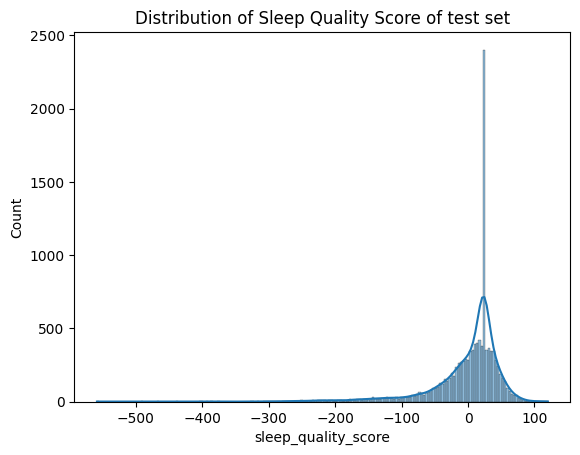

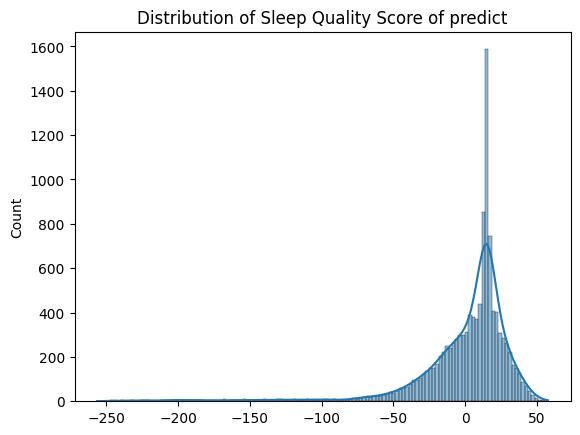

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램으로 분포 보기
sns.histplot(y_test, kde=True)
plt.title('Distribution of Sleep Quality Score of test set')
plt.show()

# 히스토그램으로 분포 보기
sns.histplot(y_pred, kde=True)
plt.title('Distribution of Sleep Quality Score of predict')
plt.show()
